_______________________________________________

# Problem Understanding,
predict the position [defense, offense, goalkeeping] for a soccer player from the average scores and the overall raiting


# Data Understanding
## Reading and extract the data from SQLite

In [3]:
 library("RSQLite")
library(DBI)
# connect to the sqlite file
con = dbConnect(RSQLite::SQLite(), dbname="Soccer.sqlite")
# get a list of all tables
alltables = dbListTables(con)
dbListTables(con) # print table names to know which one will we use 

#export Player  and Player_Attributes tables from SQLite to CSV
Player =  dbReadTable(con, "Player")
write.csv(Player, file = "Player.csv") 
P_Attributes  = dbReadTable(con, "Player_Attributes")
write.csv(P_Attributes, file = "Player_Attributes.csv")
 

[1] "Country"           "League"            "Match"            
[4] "Player"            "Player_Attributes" "Team"             
[7] "Team_Attributes"   "sqlite_sequence"

#### now we will working direct with the CSV files
#### merge the Player  and Player_Attributes to work on one file

In [10]:

Player = read.csv("Player.csv")
P_Attributes = read.csv("Player_Attributes.csv")
Players_Attributes= merge(Player,P_Attributes, by.x = "player_api_id", 
                          by.y = "player_api_id")

colnames(Players_Attributes)

[1] "player_api_id"        "X.x"                  "id.x"                
 [4] "player_name"          "player_fifa_api_id.x" "birthday"            
 [7] "height"               "weight"               "X.y"                 
[10] "id.y"                 "player_fifa_api_id.y" "date"                
[13] "overall_rating"       "potential"            "preferred_foot"      
[16] "attacking_work_rate"  "defensive_work_rate"  "crossing"            
[19] "finishing"            "heading_accuracy"     "short_passing"       
[22] "volleys"              "dribbling"            "curve"               
[25] "free_kick_accuracy"   "long_passing"         "ball_control"        
[28] "acceleration"         "sprint_speed"         "agility"             
[31] "reactions"            "balance"              "shot_power"          
[34] "jumping"              "stamina"              "strength"            
[37] "long_shots"           "aggression"           "interceptions"       
[40] "positioning"          "vision"               "penalties"           
[43] "marking"              "standing_tackle"      "sliding_tackle"      
[46] "gk_diving"            "gk_handling"          "gk_kicking"          
[49] "gk_positioning"       "gk_reflexes"

#### so the data have 50 feature some of it is not related to our problem 

# Data Preparation

#### lets remove some features [unrelated and Not Numeric] and remove the rows which have empty values

In [11]:
needed_att = Players_Attributes[,-c(1,2,3,5,6,7,8,9,10,11,12,15,16,17)]
Players_Attributes=na.omit(Players_Attributes)#remove NA

#### take the average scores for each player

In [12]:
avg_scores=apply(needed_att[,2:ncol(needed_att)],2,function(x)
    tapply(x,needed_att$player_name,mean))
                 
avg_scores=na.omit(avg_scores)

# Modeling

### Reducing dimensionality Using Principal Component Analysis.

In [13]:
avg_scores_pca=prcomp(avg_scores,scale. = T)

## so lets check the output of the PCA and see which columns we will use

In [16]:
summary(avg_scores_pca)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     4.0872 2.4098 1.86022 1.37820 1.23058 0.87532 0.75259
Proportion of Variance 0.4773 0.1659 0.09887 0.05427 0.04327 0.02189 0.01618
Cumulative Proportion  0.4773 0.6432 0.74208 0.79635 0.83962 0.86151 0.87769
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.63471 0.60510 0.58307 0.55273 0.51481 0.50645 0.48231
Proportion of Variance 0.01151 0.01046 0.00971 0.00873 0.00757 0.00733 0.00665
Cumulative Proportion  0.88920 0.89966 0.90937 0.91810 0.92568 0.93300 0.93965
                          PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.47527 0.4386 0.42009 0.41387 0.38841 0.37387 0.35638
Proportion of Variance 0.00645 0.0055 0.00504 0.00489 0.00431 0.00399 0.00363
Cumulative Proportion  0.94610 0.9516 0.95664 0.96154 0.96585 0.96984 0.97347
                         PC22    PC23 

### to see the global picture and the major clusters we will use smooth scatter

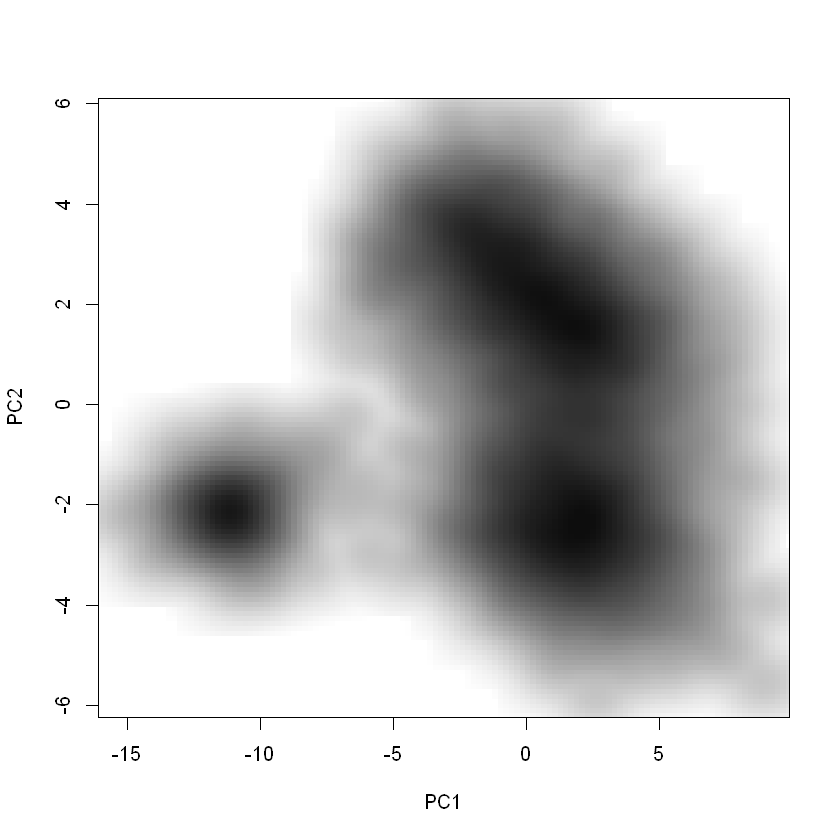

In [17]:
smoothScatter(avg_scores_pca$x[,1:2],nrpoints = 0, 
              colramp = colorRampPalette(c("white", "gray5")))

### it seems that there is 3 Clusters in our data so lets applay Kmeans with K = 3 and print a summary for each cluster  and plot them 

player_classes_Kmean3
   1    2    3 
5078  832 3757 

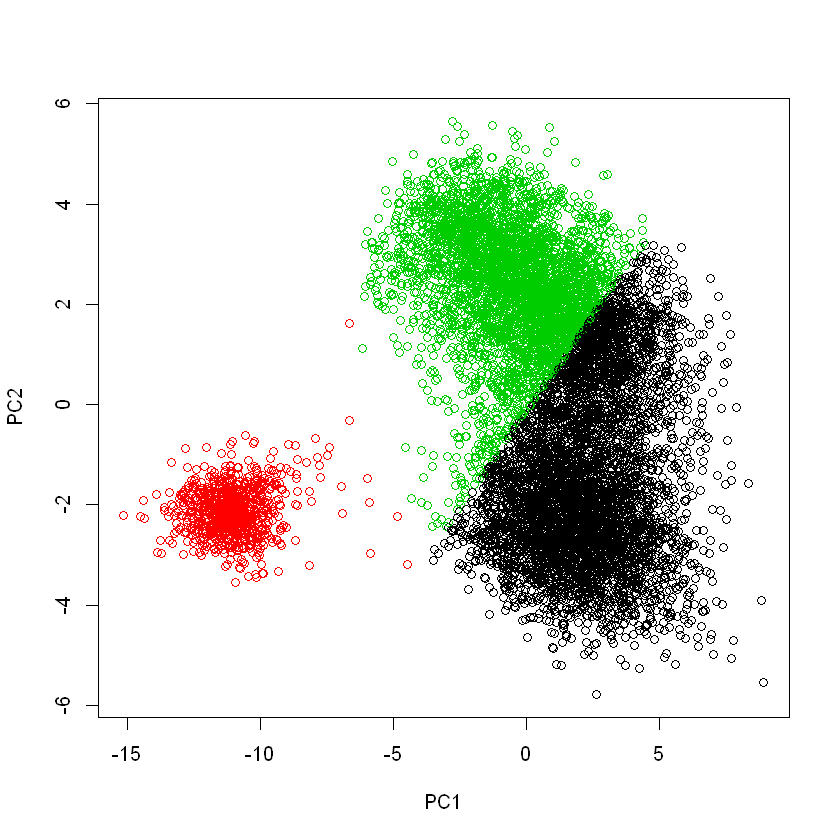

In [49]:
comp <- data.frame(avg_scores_pca$x[,1:2])
k <- kmeans(comp, 3, nstart=25)
player_classes_Kmean3 = k$cluster
table(player_classes_Kmean3)
plot(comp, col=player_classes_Kmean3)

### lets print some of the players name in each one and see if he is a Goalkeeper or play as attacker or defense

In [50]:
names(player_classes_Kmean3[player_classes_Kmean3==1][1:5])
names(player_classes_Kmean3[player_classes_Kmean3==2][1:5])
names(player_classes_Kmean3[player_classes_Kmean3==3][1:5])

[1] "Aaron Cresswell" "Aaron Doran"     "Aaron Hunt"      "Aaron Lennon"   
[5] "Aaron Meijers"

[1] "Aaron Lennox"     "Abdoulaye Diallo" "Achille Coser"    "Adam Bogdan"     
[5] "Adam Collin"

[1] "Aaron Appindangoye" "Aaron Galindo"      "Aaron Hughes"      
[4] "Aaron Kuhl"         "Aaron Mokoena"

### for me, it seems that k-Mean with k = 3 classify the goalkeepers good but fail with classify defender and attacker it is okay becouse some players play as Midfielder and thay have good defence and attacking skills so lets try to add another cluster

player_classes_Kmean4
   1    2    3    4 
2660 3567  829 2611 

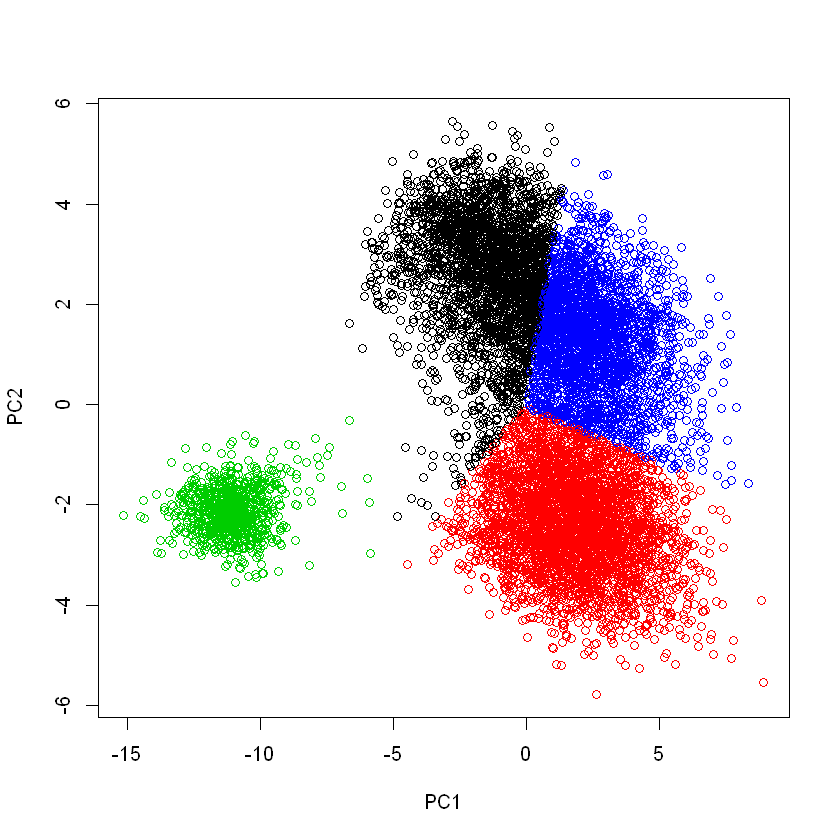

In [70]:
k <- kmeans(comp, 4, nstart=25)
player_classes_Kmean4 = k$cluster
table(player_classes_Kmean4)
plot(comp, col=player_classes_Kmean4)

In [72]:
names(player_classes_Kmean4[player_classes_Kmean4==1][100:105])
names(player_classes_Kmean4[player_classes_Kmean4==2][100:105])
names(player_classes_Kmean4[player_classes_Kmean4==3][100:105])
names(player_classes_Kmean4[player_classes_Kmean4==4][100:105])

[1] "Alessandro Gamberini"   "Alessandro Lambrughi"   "Alessandro Lucarelli"  
[4] "Alessandro Mangiarrati" "Alessandro Nesta"       "Alessio Romagnoli"

[1] "Akpo Sodje"    "Alain Schultz" "Alain Traore"  "Alan"         
[5] "Alan Kardec"   "Alan O'Brien"

[1] "Bogdan Lobont"       "Bojan Jorgacevic"    "Boris Peskovic"     
[4] "Boris Radunovic"     "Boubacar Barry Copa" "Boy Waterman"

[1] "Alexander Meier"       "Alexander Ring"        "Alexandre Coeff"      
[4] "Alexandre Hauw"        "Alexandros Tziolis"    "Alexis Norambuena Ruz"

### i used google to give me some information about the actual position for this names and my observation is:
    # 1st cluster is for defender
    # 2nd cluster is for attacker
    # 3rd cluster is for goalkeeper
    # 4th cluster is for Midfielder

In [59]:
colnames(avg_scores)

[1] "overall_rating"     "potential"          "crossing"          
 [4] "finishing"          "heading_accuracy"   "short_passing"     
 [7] "volleys"            "dribbling"          "curve"             
[10] "free_kick_accuracy" "long_passing"       "ball_control"      
[13] "acceleration"       "sprint_speed"       "agility"           
[16] "reactions"          "balance"            "shot_power"        
[19] "jumping"            "stamina"            "strength"          
[22] "long_shots"         "aggression"         "interceptions"     
[25] "positioning"        "vision"             "penalties"         
[28] "marking"            "standing_tackle"    "sliding_tackle"    
[31] "gk_diving"          "gk_handling"        "gk_kicking"        
[34] "gk_positioning"     "gk_reflexes"

# Evaluation

## lets se if we are correct or not we will use the most important feature for each position (eg.)
    # for attacker the finishing is the most important
    # for defender the interceptions is the most important
    # for goalkeeper the gk_reflexes is the most important
    # for Midfielder should be high in both interceptions and finishing

In [73]:
colnames(avg_scores)

[1] "overall_rating"     "potential"          "crossing"          
 [4] "finishing"          "heading_accuracy"   "short_passing"     
 [7] "volleys"            "dribbling"          "curve"             
[10] "free_kick_accuracy" "long_passing"       "ball_control"      
[13] "acceleration"       "sprint_speed"       "agility"           
[16] "reactions"          "balance"            "shot_power"        
[19] "jumping"            "stamina"            "strength"          
[22] "long_shots"         "aggression"         "interceptions"     
[25] "positioning"        "vision"             "penalties"         
[28] "marking"            "standing_tackle"    "sliding_tackle"    
[31] "gk_diving"          "gk_handling"        "gk_kicking"        
[34] "gk_positioning"     "gk_reflexes"

In [74]:
player_classes_Kmean4[which(player_classes_Kmean4==1)]="defender"
player_classes_Kmean4[which(player_classes_Kmean4==2)]="attacker"
player_classes_Kmean4[which(player_classes_Kmean4==3)]="goalkeeper"
player_classes_Kmean4[which(player_classes_Kmean4==4)]="midfielder"
player_classes_Kmean4=factor(player_classes_Kmean4, 
            levels = c("defender", "attacker", "goalkeeper","midfielder"))

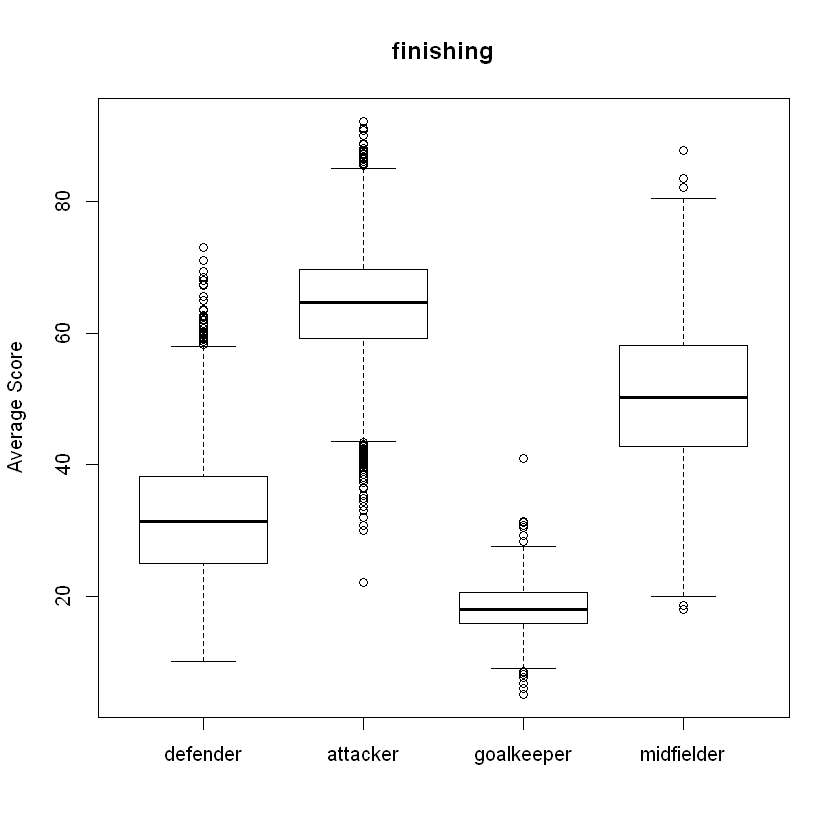

In [75]:
k=4
boxplot(avg_scores[,k]~player_classes_Kmean4,main=colnames(avg_scores)[k],
ylab="Average Score")

## So yes as we expected finishing is high for both attacker and midfielder



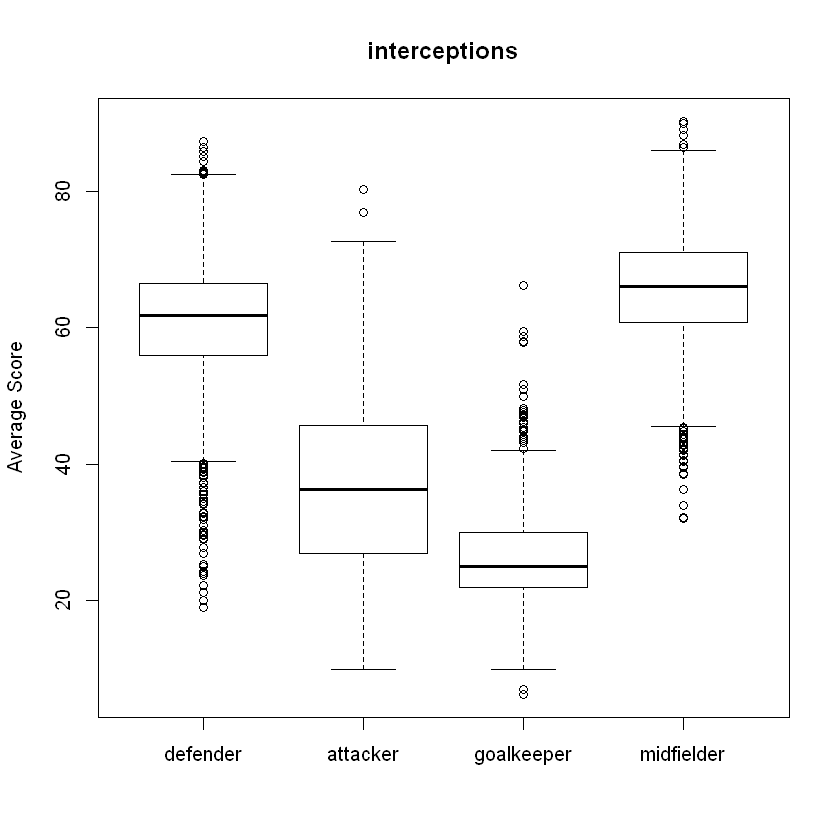

In [76]:
k=24
boxplot(avg_scores[,k]~player_classes_Kmean4,main=colnames(avg_scores)[k],
ylab="Average Score")

## and interceptions is high for both defender and midfielder

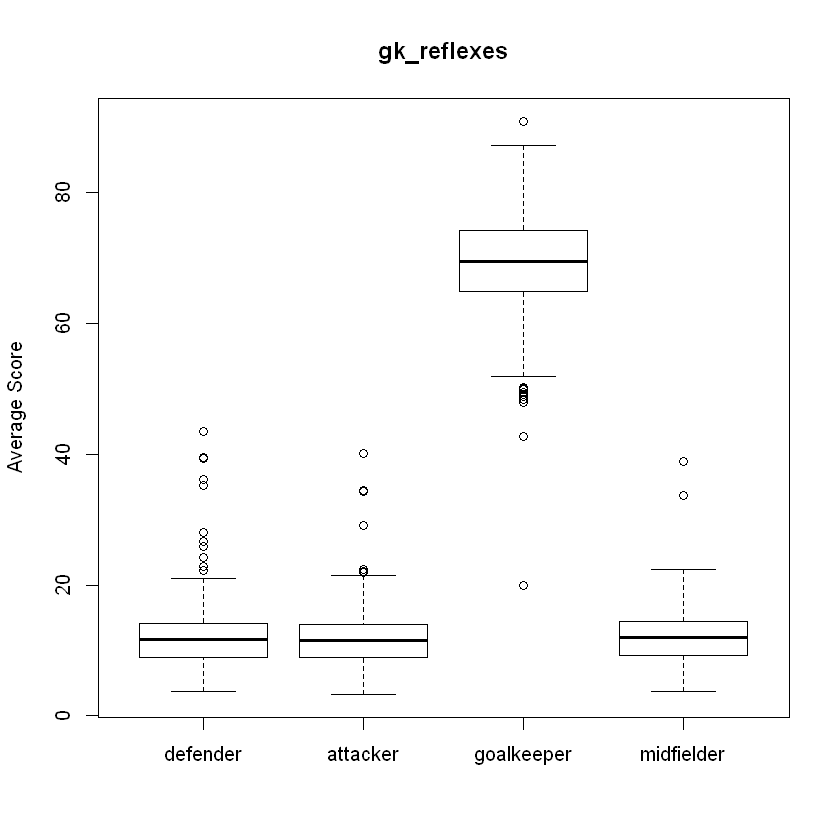

In [78]:
k=35
boxplot(avg_scores[,k]~player_classes_Kmean4,main=colnames(avg_scores)[k],
ylab="Average Score")

## and gk_reflexes is high for goalkeeper

# Deploymen

### the code and the CSV data file hosted on github

https://github.com/m4bulmagd/Data-Mining-Report-JMU

________________________________